# Imports

In [1]:
from matplotlib import pyplot as plt
import pickle
import os
import pandas as pd
import numpy as np
import sklearn
import statistics
from constants import SUPPORTED_ARCHITECTURES
from constants import ARCHITECTURE_KEY


In [ ]:
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# Utilities

In [28]:
def is_saving_dir(directory):
    directory = str(directory)
    # directory = directory.split('/')[-1]
    if "saving_dir" in directory:
        return True
    else: return False

def get_experiment_id(saving_dir):
    path = str(saving_dir)
    directory = path.split('/')[-1]
    last_char = directory[-1]
    experiment_id = int(last_char)
    return experiment_id

def get_model(architecture, _id, EXPERIMENTS_PATH):
    path = os.path.join(EXPERIMENTS_PATH, "saving_dir"+_id, architecture+"_models.pickle")
    with open(path, 'rb') as pickle_file:
        loaded_file = pickle.load(pickle_file)
    return loaded_file

def get_experiments(EXPERIMENTS_PATH):
    rootdir = EXPERIMENTS_PATH
    experiments = []

    for subdir, dirs, files in os.walk(rootdir):
        if is_saving_dir(subdir):
            experiment = {}
            experiment["id"] = get_experiment_id(subdir)
            for file in files:
                path  = os.path.join(subdir, file)
                with open(path, 'rb') as pickle_file:
                    if file.endswith("evaluations.pickle"):
                        architecture_not_supported = True
                        for architecture in SUPPORTED_ARCHITECTURES:
                            if architecture in file:
                                experiment[architecture]  = pickle.load(pickle_file)
                                architecture_not_supported = False
                        if architecture_not_supported:
                            raise Exception("Architecture for file {} not supported".format(file))

            experiments.append(experiment)
    return experiments

def get_median_target_experiment(target, experiments, architecture):
    target_experiments = [] 
    
    for i in range(len(experiments)):
        target_experiment = {
            "id":experiments[i]["id"],
            "evaluations":experiments[i][architecture][target][ARCHITECTURE_KEY[architecture]],
            # "evaluations":experiments[i]["evaluations"][target][architecture],
            # "models":experiments[i]["models"][target][architecture]
            }

        target_experiments.append(target_experiment)

    sorted_target_experiments = sorted(target_experiments, key=lambda d: d['evaluations']['rmse']) 
    median_target_experiment = sorted_target_experiments[int(len(sorted_target_experiments)//2)]
    return median_target_experiment

def get_mean_rmse_dev(target,experiments,architecture):
    rmses = []
    rmse_sum = 0.0
    for i in range(len(experiments)):
        rmse = experiments[i][architecture][target][ARCHITECTURE_KEY[architecture]]['rmse']
        rmses.append(rmse)
        rmse_sum += rmse
    std_dev = statistics.stdev(rmses)
    rmse_avg = rmse_sum/len(experiments)
    return rmse_avg, std_dev

def filenameify(s):
    return "".join(x for x in s if x.isalnum())

def histogram(RESULTS_SAVING_PATH, target, errors):
    
    fig = plt.figure(figsize =(10, 7))
    
    counts, bins = np.histogram(np.abs(errors),bins=100)
    plt.stairs(counts, bins)

    plt.title("{} Error Histogram".format(target))
        
    save_path = RESULTS_SAVING_PATH+'/'+filenameify(target)+'.png'
    
    plt.savefig(save_path, bbox_inches='tight')

def histogram(RESULTS_SAVING_PATH, target, errors):
    
    fig = plt.figure(figsize =(10, 7))
    
    counts, bins = np.histogram(np.abs(errors),bins=100)
    plt.stairs(counts, bins)

    plt.title("{} Error Histogram".format(target))
        
    save_path = RESULTS_SAVING_PATH+'/'+filenameify(target)+'.png'
    
    plt.savefig(save_path, bbox_inches='tight')

# Analysis

In [3]:
root = "c:/Users/evan_/Documents/GitHub/sensors_project/"
EXPERIMENTS_PATH = root + "model/experiments/"
DATA_PATH = root + "data/river_sensor_data.csv"


df = pd.read_csv(DATA_PATH)

targets = df.columns.to_list()

experiments = get_experiments(EXPERIMENTS_PATH)

In [41]:
nitrogen_target = 'NO3+NO2-N-Diss-Water (NITRATE + NITRITE NITROGEN) (mg/L) Result'


for architecture in SUPPORTED_ARCHITECTURES:
     median_target_experiment = get_median_target_experiment(nitrogen_target,experiments,architecture)
     median_target_experiment_id = str(median_target_experiment['id'])
     my_dict = get_model(architecture, median_target_experiment_id, EXPERIMENTS_PATH)[nitrogen_target]
     best_params = my_dict[list(my_dict.keys())[0]].best_params_
     

     print("The optimal hyperparameters found by the GridSearchCV module for the {} architecture when predicting the {} target are {}".format(architecture, nitrogen_target, best_params))


The optimal hyperparameters found by the GridSearchCV module for the MLP architecture when predicting the NO3+NO2-N-Diss-Water (NITRATE + NITRITE NITROGEN) (mg/L) Result target are {'activation': 'relu', 'hidden_layer_sizes': 7}
The optimal hyperparameters found by the GridSearchCV module for the RF architecture when predicting the NO3+NO2-N-Diss-Water (NITRATE + NITRITE NITROGEN) (mg/L) Result target are {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 500}
The optimal hyperparameters found by the GridSearchCV module for the KNN architecture when predicting the NO3+NO2-N-Diss-Water (NITRATE + NITRITE NITROGEN) (mg/L) Result target are {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
The optimal hyperparameters found by the GridSearchCV module for the LASSO architecture when predicting the NO3+NO2-N-Diss-Water (NITRATE + NITRITE NITROGEN) (mg/L) Result target are {'alpha': 0.09}


{'activation': 'relu', 'hidden_layer_sizes': 7}

In [10]:
best_rmse = None
best_target=None

for architecture in SUPPORTED_ARCHITECTURES:
    for target in targets:
        mean_rmse, std_dev = get_mean_rmse_dev(target,experiments,architecture)
        # find out which target we perform best for
        if best_rmse is None:
            best_rmse = mean_rmse
            best_target = target
        elif best_rmse >= mean_rmse:
            best_rmse = mean_rmse
            best_target = target
    print("The {} Architecture performs best when predicting {} target, with a mean rmse of {}".format(architecture, best_target, best_rmse))


The MLP Architecture performs best when predicting F-Diss-Water (FLUORIDE) (mg/L) Result target, with a mean rmse of 0.3581744591835576
The RF Architecture performs best when predicting F-Diss-Water (FLUORIDE) (mg/L) Result target, with a mean rmse of 0.3235156902864303
The KNN Architecture performs best when predicting F-Diss-Water (FLUORIDE) (mg/L) Result target, with a mean rmse of 0.3235156902864303
The LASSO Architecture performs best when predicting F-Diss-Water (FLUORIDE) (mg/L) Result target, with a mean rmse of 0.3235156902864303


In [6]:
nitrogen_target = 'NO3+NO2-N-Diss-Water (NITRATE + NITRITE NITROGEN) (mg/L) Result'

In [31]:
for architecture in SUPPORTED_ARCHITECTURES:

    for target in targets:
        mean_rmse, std_dev = get_mean_rmse_dev(nitrogen_target,experiments,architecture)

    print("The {} Architecture achieves a mean rmse of {} with std dev {} for the NO3+NO2-N-Diss-Water (mg/L) target  ".format(architecture, mean_rmse, std_dev))

The MLP Architecture achieves a mean rmse of 5.722230286745741 with std dev 1.8392053760924199 for the NO3+NO2-N-Diss-Water (mg/L) target  
The RF Architecture achieves a mean rmse of 4.4252472866065755 with std dev 1.4930975011199228 for the NO3+NO2-N-Diss-Water (mg/L) target  
The KNN Architecture achieves a mean rmse of 3.643197826186036 with std dev 1.4284218904593338 for the NO3+NO2-N-Diss-Water (mg/L) target  
The LASSO Architecture achieves a mean rmse of 5.649963633880724 with std dev 1.2213008800534568 for the NO3+NO2-N-Diss-Water (mg/L) target  


In [30]:
std_dev

1.2213008800534568

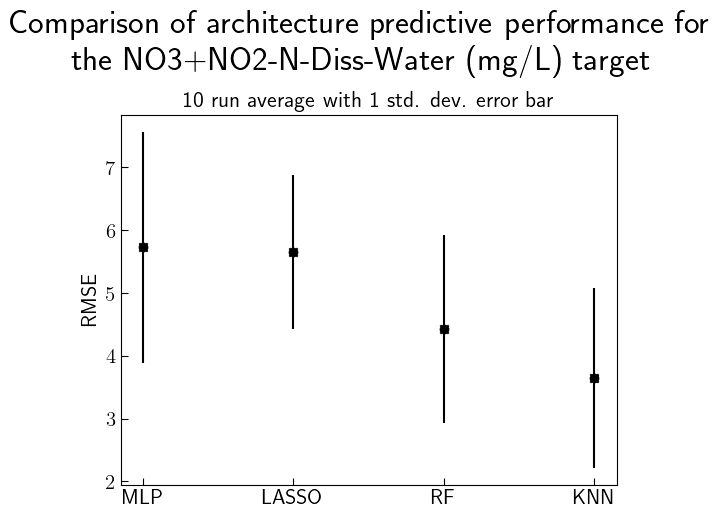

In [42]:
c = [1, 3, 2, 1]
names = ['MLP '  , 'LASSO ' , 'RF ' , 'KNN ']
values = [ 5.722230286745741  , 5.649963633880724 , 4.4252472866065755 ,  3.643197826186036]
std_dev = [1.8392053760924199 ,1.2213008800534568, 1.4930975011199228, 1.4284218904593338 ]

# fig, axs = plt.subplots(1, 1, figsize=(9, 3), sharey=True)

plt.scatter(names, values,marker='x',c='black')

plt.errorbar(names, values, yerr=std_dev, fmt="o", c='black')

plt.title('10 run average with 1 std. dev. error bar',fontsize=16)
plt.suptitle('Comparison of architecture predictive performance for \n the NO3+NO2-N-Diss-Water (mg/L) target',fontsize=24, y=1.1)

plt.ylabel("RMSE ")
# plt.xlabel("Architecture")
plt.show()
